# OPTION 2 : Un modèle unique

Tout classique, on doit utiliser un  modèle qui sait gérer le multi classes unbalanced

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [5]:
def load_data(file,data_path=DATA_PROCESSED, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

# On load des données


In [6]:
TX_data = load_data(file = "working_data.csv");
TX_data=TX_data.apply(pd.to_numeric, errors='ignore')

In [7]:
TX_data.head()

,WARRANTIES_FLG,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,REGISTRATION_DATE,BUYER_BIRTHDAY_DATE,BUYER_DEPARTMENT,SELLER_SCORE_AVERAGE,SELLER_COUNTRY,...,Count_BUYER_ID,Mean_BUYER_ID,STD_BUYER_ID,Count_Claims_BUYER_ID,Count_SELLER_ID,Mean_SELLER_ID,STD_SELLER_ID,Count_Claims_SELLER_ID,PCA_1,PCA_2
0,0,1,0,1,0,2015,1992.0,34,46.0,"FRANCE, METROPOLITAN",...,5.0,0.800000,0.447214,4.0,44.0,0.5,0.505781,22.0,-203876.663031,-25937.586104
1,0,1,0,1,0,2014,1981.0,93,46.0,"FRANCE, METROPOLITAN",...,4.0,0.750000,0.500000,3.0,44.0,0.5,0.505781,22.0,-304465.724332,-25696.909632
2,0,1,0,0,0,2017,0.0,35,46.0,"FRANCE, METROPOLITAN",...,39.0,0.256410,0.442359,10.0,44.0,0.5,0.505781,22.0,-203876.778030,-25937.948454
3,0,0,1,0,0,2014,1964.0,92,46.0,"FRANCE, METROPOLITAN",...,7.0,0.285714,0.487950,2.0,44.0,0.5,0.505781,22.0,-203876.650358,-25937.610064
4,0,1,0,0,0,2013,1989.0,25,46.0,"FRANCE, METROPOLITAN",...,2.0,1.000000,0.000000,2.0,44.0,0.5,0.505781,22.0,-203876.657771,-25937.579497


In [8]:
#TX_data.info()

In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )

In [10]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    Y=data["CLAIM_TYPE"]
    X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [11]:
X_train,Y_train=datapreprocess(train_set)
X_test, Y_test=datapreprocess(test_set)

del train_set, test_set;
gc.collect()

27

In [13]:
## test Rapide

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(truth, pred):
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [14]:
# Modèle trouvé grâce à la cross validation
from sklearn.ensemble import RandomForestClassifier
rnd_clf= RandomForestClassifier(
                                bootstrap=True, 
                                class_weight='balanced_subsample', 
                                criterion='gini',
                                #max_depth=None, 
                                #max_features='auto', 
                                #max_leaf_nodes=18,
                                #min_impurity_decrease=0.0, 
                                #min_impurity_split=None,
                                #min_samples_leaf=1, 
                                #min_samples_split=2,
                                #min_weight_fraction_leaf=0.0, 
                                #n_estimators=50, 
                                n_jobs=1,
                                #oob_score=True, 
                                random_state=RANDOM_SEED, 
                                verbose=0, 
                                warm_start=False)


In [15]:
rnd_clf.fit(X_train, Y_train);
y_pred_rf = rnd_clf.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

                          precision    recall  f1-score   support

                       -       0.70      0.88      0.78      9996
                 DAMAGED       0.24      0.16      0.19      1184
               DIFFERENT       0.25      0.13      0.17       856
                    FAKE       0.27      0.12      0.17        33
            NOT_RECEIVED       0.46      0.43      0.44      2962
SELLER_CANCEL_POSTERIORI       0.47      0.41      0.44      2756
               UNDEFINED       0.34      0.15      0.21       813
              WITHDRAWAL       0.32      0.17      0.22      1400

             avg / total       0.55      0.59      0.56     20000



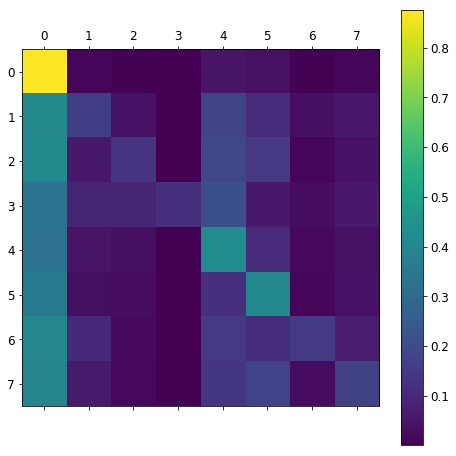

In [18]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
conf_mx = confusion_matrix(Y_test, y_pred_rf)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

### Bilan: 

On prédit bien les zones en CLAIMS, donc ça peut être bien pour la suite.

In [ ]:
params_cv_long = {#'bootstrap':[True, False], 
                  'max_leaf_nodes':[2, 4, 8, 12, 16, 18],
                  'min_samples_leaf':list(range(1, 6)), 
                  'min_samples_split':list(range(2, 4)),
                  'n_estimators':list(range(10, 100, 25))
         }

In [ ]:
rf_to_cv= RandomForestClassifier(
                                    random_state=RANDOM_SEED,
                                    criterion='gini',
                                    max_features='auto',
                                    class_weight='balanced_subsample',
                                    oob_score=False,
                                    verbose=0,
                                    warm_start=False
                                )

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_gs_cv = GridSearchCV(
                        estimator=rf_to_cv, 
                        param_grid=params_cv_long,
                        scoring='roc_auc',
                        n_jobs=-1, 
                        verbose=1, 
                        cv= 5
                        )

In [ ]:
rf_gs_cv.fit(X_train, Y_train)

In [ ]:
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test)

In [ ]:
print("ROC score : {}".format(roc_auc_score(Y_test, y_pred_cv_rf)))

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
plot_confusion_matrix(conf_mx)

## Bon, on a bien rigolé, maintenant on essaie tout les algos possibles

In [19]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB, GaussianNB
clf_BernoulliNB = BernoulliNB()
clf_GaussianNB = GaussianNB()

# Tree
from sklearn.tree import DecisionTreeClassifier
clf_DecisionTreeClassifier = DecisionTreeClassifier()

# Ensemble
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
clf_GradientBoostingClassifier = GradientBoostingClassifier()
clf_ExtraTreeClassifier = ExtraTreesClassifier()
clf_AdaBoostClassifier = AdaBoostClassifier()

# Neighbors
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
clf_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=3)
clf_NearestCentroid = NearestCentroid()
clf_RNC = RadiusNeighborsClassifier()

# Semi Supervised
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
clf_LabelPropagation = LabelPropagation()
clf_LabelSpreading = LabelSpreading()

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
clf_LDA = LinearDiscriminantAnalysis()
clf_QDA = QuadraticDiscriminantAnalysis()

# Linear Models
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
clf_SGDClassifier = SGDClassifier()
clf_LogisticRegressionCV = LogisticRegressionCV()
clf_Perceptron = Perceptron()
clf_PassiveAggressiveClassifier = PassiveAggressiveClassifier()
clf_RidgeClassifier=RidgeClassifier()

from sklearn.gaussian_process import GaussianProcessClassifier
clf_GaussianProcessClassifier = GaussianProcessClassifier()

In [20]:
list_models=[clf_BernoulliNB,
            #clf_GaussianNB,
            clf_DecisionTreeClassifier,
            clf_GradientBoostingClassifier,
            clf_ExtraTreeClassifier,
            clf_AdaBoostClassifier,
            #clf_KNeighborsClassifier,
            #clf_NearestCentroid,
            #clf_RNC,
            #clf_LabelPropagation,
            #clf_LabelSpreading,
            #clf_LDA,
            #clf_QDA,
            #clf_SGDClassifier,
            clf_LogisticRegressionCV,
            #clf_Perceptron,
            #clf_PassiveAggressiveClassifier,
            #clf_RidgeClassifier,
            #clf_GaussianProcessClassifier
            ]

In [ ]:
for clf in list_models:
    try:
        clf.fit(X_train,Y_train)
        y_pred = clf.predict(X_test)
        print(str(clf.__class__.__name__)+" : "+ str(multiclass_roc_auc_score(Y_test, y_pred)))
        del clf
    except:
        print(str(clf.__class__.__name__)+" : Error")
        del clf

In [25]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import f1_score 

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=list_models, 
                          meta_classifier=lr)
list_models.append(sclf)

In [27]:
labels = [
            'BernoulliNB',
            'DecisionTreeClassifier',
            'GradientBoostingClassifier',
            'ExtraTreeClassifier',
            'AdaBoostClassifier',
            #'KNeighborsClassifier',
            #'LDA',
            #'SGDClassifier',
            'LogisticRegressionCV', 
            'Stacking'
            ]

In [ ]:
print('3-fold cross validation:\n')

for clf, label in zip(list_models, 
                      labels):

    scores = model_selection.cross_val_score(clf, X_train, Y_train, 
                                              cv=3, scoring='f1_weighted')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.44 (+/- 0.00) [BernoulliNB]
Accuracy: 0.52 (+/- 0.00) [DecisionTreeClassifier]
Accuracy: 0.55 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 0.56 (+/- 0.00) [ExtraTreeClassifier]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.50 (+/- 0.01) [AdaBoostClassifier]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.36 (+/- 0.00) [LogisticRegressionCV]


In [ ]:
# MODEL!

In [ ]:
## Scaler

Inutile pour les arbres, mais utiles pour les autres

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
## Normalizer

In [ ]:
from sklearn.preprocessing import Normalizer
normy = Normalizer()

In [ ]:
# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
# Feature Union

In [ ]:
from sklearn.pipeline import FeatureUnion

from sklearn.decomposition import KernelPCA
estimators = [('linear_pca', PCA(n_components=5)), 
                  ('kernel_pca', KernelPCA(n_components=5))]
combined = FeatureUnion(estimators)

In [ ]:
#combined.fit_transform(X_train)

# Feature Selection

## Selection des variables avec une variance faible

Ici, on vire tout ce qu'il y a une probabilité de 0.8 d'être la 

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
sel_vt = VarianceThreshold(threshold=(.8 * (1 - .8)))

## Selection des K meilleures variables d'après le test de Chi2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
Nb_Var = 15

In [ ]:
Chi_select = SelectKBest(chi2, k=Nb_Var)
del Nb_Var

In [ ]:
## Selection par rapport à un modèle

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

### Modèle de Selection

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, 
                             random_state=RANDOM_SEED)

In [ ]:
### Contruction

In [ ]:
sfm_clf = SelectFromModel(clf)
del clf

# Metriques

D'abord, notre métrique à nous

In [ ]:
### Calcul l'AUC de chaque classe

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def multiclass_roc_auc_score(truth, pred):
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [ ]:
### precision_class_AUC (pas safe), est utilisée pour le scoring de modèle (version adaptée de précédement)

In [ ]:
def precision_class_AUC(estimator, X, y):
    return multiclass_roc_auc_score(y, estimator.predict(X))

In [ ]:
## Model!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rnd_clf = RandomForestClassifier(n_jobs=-1, 
                                 random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_clf=GradientBoostingClassifier(random_state=RANDOM_SEED)

In [ ]:
# Et on pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
clf = Pipeline([
    #('scaler', scaler), 
    #('norm', normy), 
    #('threshold', sel_vt), 
    #('SelectKBest', Chi_select), 
    #('reduce_dim', pca),
    #('feature_union', combined),
    #('feature_selection', sfm_clf),
    ('classification', gb_clf)
])


clf.fit(X_train, Y_train);
y_pred_rf = clf.predict(X_test)
multiclass_roc_auc_score(Y_test, y_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
conf_mx = confusion_matrix(Y_test, y_pred_rf)
plot_confusion_matrix(conf_mx)

In [ ]:
params = {'max_leaf_nodes': [4, 8],
          'max_depth' : [2, 4], 
          'n_estimators': [250, 500],
          'min_samples_leaf': list(range(1, 3)),
          'min_samples_split' : list(range(2, 3)),
         }

In [ ]:
rf_gs_cv = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, oob_score=True),
                              params,
                              scoring='f1_weighted',
                              n_jobs=-1, 
                              verbose=1)

In [ ]:
rf_gs_cv.fit(X_train, Y_train)

In [ ]:
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test) 

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_cv_rf)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [ ]:
params_cv_long = {'bootstrap':True, 
                  'class_weight':None, 
                  'criterion':'gini',
                  'max_depth':None, 
                  'max_features':'auto', 
                  'max_leaf_nodes':[4, 8, 12, 16, 18],
                  'min_impurity_decrease':0.0, 
                  'min_impurity_split':None,
                  'min_samples_leaf':list(range(1, 6)), 
                  'min_samples_split':list(range(2, 4)),
                  'min_weight_fraction_leaf':0.0, 
                  'n_estimators':[100, 250, 500], 
                  'n_jobs':-1,
                  'oob_score':False, 
                  'random_state':RANDOM_SEED, 
                  'verbose':0, 
                  'warm_start':False
         }

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_SEED))),
  ('classification', GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), 
                              params,
                              scoring='f1_weighted',
                              n_jobs=-1, 
                              verbose=1))
])


In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_jobs=-1,random_state=RANDOM_SEED))),
  ('classification', RandomForestClassifier(, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_SEED,
                                 ))
])


In [ ]:
clf.fit(X_train, Y_train)

In [ ]:
y_pred_rf = clf.predict(X_test)

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_rf)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'max_leaf_nodes': [4, 8],
          'max_depth' : [2, 4], 
          'n_estimators': list(range(10, 50, 10)),
          'min_samples_leaf': list(range(1, 3)),
          'min_samples_split' : list(range(2, 3)),
         }

In [ ]:
rf_gs_cv = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, oob_score=True),
                              params,
                              scoring=precision_class_AUC,
                              n_jobs=-1, 
                              verbose=1)

In [ ]:
rf_gs_cv.fit(X_train, Y_train)
rf_gs_cv.best_estimator_

In [ ]:
y_pred_cv_rf = rf_gs_cv.predict(X_test) 

In [ ]:
multiclass_roc_auc_score(Y_test, y_pred_cv_rf)

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
plot_confusion_matrix(conf_mx)